Extracting returns signals from Microsoft's LOB for OB data for April 2018
===

In [1]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
from sklearn.metrics import classification_report, accuracy_score
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

Initialising some utility functions, extracting data from LOBster data, calculation of cumulative returns over the month
===

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of
    
from scipy import stats
def taglia_e_cuci(v):
    hi=np.quantile(v,0.005)
    lo=np.quantile(v, 0.995)
    b=np.clip(v, hi,lo)
    return b
    
def baSpread(x):
    a=x['AP1'].values.tolist()
    b=x['BP1'].values.tolist()
    bas=np.empty(len(x))
    for i in range(len(a)):
       bas[i]=(a[i]-b[i])#/(a[i]+b[i])*10**4
    return bas

In [3]:
msg_files = glob("MSFT_NUOVO/*message*.csv")
lob_files = glob("MSFT_NUOVO/*order*.csv")
d0 = datetime(2018,4,2)

In [4]:
dfs = []
for day, file in enumerate(np.sort(msg_files)[:]):
    te = pd.read_csv(file, header=None, low_memory=False)
    te['Day'] = d0 + BDay(day)
    dfs.append(te)
df_msg = pd.concat(dfs)

print("{0:0.2f} million observations".format(len(df_msg)/10**6))
df_msg.columns = ['Time', 'Event', 'ID', 'Size', 'Price', 'Direction', '?', 'Day']
df_msg = df_msg.drop(['?'], axis=1)
df_msg['Execution'] = np.where(df_msg['Event'].isin([4,5]), 1, 0)
# 4: Execution of a visible limit order
# 5: Execution of a hidden limit order

28.98 million observations


In [5]:
df_msg_exe=df_msg[df_msg['Execution']==1]
print("{0:0.2f} million observations".format(len(df_msg_exe)/10**6))

1.25 million observations


In [6]:

dfs = []
for file in np.sort(lob_files)[:]:
    te = pd.read_csv(file, header=None)
    dfs.append(te)
df_lob  = pd.concat(dfs)
cols = np.ravel([['AP%d'%level, 'AS%d'%level, 'BP%d'%level, 'BS%d'%level] for level in [1,2,3,4,5]])
df_lob.columns = cols
print("{0:0.2f} million observations".format(len(df_lob)/10**6))

28.98 million observations


In [7]:
df_lob.reset_index(inplace=True)
df_msg.reset_index(inplace=True)
df = pd.concat([df_msg, df_lob], axis=1)
df = df[df['Execution']==1]
df.dropna(inplace=True)
lob_data=df[cols]
lob_data.head()

,AP1,AS1,BP1,BS1,AP2,AS2,BP2,BS2,AP3,AS3,BP3,BS3,AP4,AS4,BP4,BS4,AP5,AS5,BP5,BS5
0,904800,4315,904400,374,905200,100,904000,50,905300,1730,903500,100,905600,100,903000,200,907000,100,902500,200
1,904800,4004,904400,374,905200,100,904000,50,905300,1730,903500,100,905600,100,903000,200,907000,100,902500,200
2,904800,4004,904400,374,905200,100,904000,50,905300,1730,903500,100,905600,100,903000,200,907000,100,902500,200
3,904800,4004,904400,374,905200,100,904000,50,905300,1730,903500,100,905600,100,903000,200,907000,100,902500,200
5,904800,4004,904400,374,905200,100,904000,50,905300,2825,903500,100,905600,100,903000,200,907000,100,902500,200


In [8]:
lob_data=lob_data.iloc[:int(len(lob_data)*0.5)]
lob_data.shape

(624034, 20)

In [9]:
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
bas=pd.DataFrame(baSpread(lob_data),columns=['bas'])
bas['diff']=bas.pct_change()
of_data.dropna(inplace=True)
bas.dropna(inplace=True)
bas.reset_index(inplace=True)
ba=bas['diff'].to_numpy()
ba=taglia_e_cuci(ba)
lo=0.05#np.quantile(ba, 0.05)
hi=0.95#np.quantile(ba, 0.95)
vec = np.zeros(len(of_data))
for i in range(len(bas)-1):
    if (bas.loc[i+1,'diff']) > (1+hi)*(bas.loc[i,'diff']):#
        vec[i] = 1
    elif  (bas.loc[i+1,'diff']) < (1+lo)*(bas.loc[i,'diff']):#
        vec[i] = -1


Prepares the dataset: cuts at 0.5% the tails, and splits data in the requested formats
===

In [10]:
def prepare_x_y(data, lag, dimension):
    '''
    lag: the order of the VAR process, or the lookback window in the sequential model
    dimension: number of variables in the time series
    '''
    data = data
    shape = data.shape
    X = np.zeros((shape[0]-lag, lag, dimension))
    Y = np.zeros((shape[0]-lag, 1)) # 1 for the number of forecasting horizons
    for i in range(shape[0]-lag):
        X[i] = data[i:i+lag, :dimension] # take the variables' columns as features
        Y[i] = data[i+lag-1, -1:] # take the last column as labels
    X = X.reshape(X.shape[0], lag, dimension, 1)
    
    Y += 1 # relabel as 0, 1, 2
    
    Y = np_utils.to_categorical(Y.astype(int),3) # format channel as binary vector where 1 is in the position of the true mid price change
    
    return X,Y


In [11]:
train_weight=0.9
vali_weight=0.05


train=of_data.iloc[:int(len(of_data)*train_weight)]
validation=of_data.iloc[int(len(of_data)*train_weight):int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)]
test=of_data.iloc[int(len(of_data)*train_weight)+int(len(of_data)*vali_weight):]
n_train=taglia_e_cuci(train)
n_vali =taglia_e_cuci(validation)
n_test =taglia_e_cuci(test)

for col in train.columns:#'aOF_1',	'bOF_1',	'aOF_2',	'bOF_2',	'aOF_3',	'bOF_3']:
    mu = float(train.loc[:,col].mean())
    sigma = float(train.loc[:,col].std())
    stdize_input = lambda x: (x-mu)/sigma#normalizer.fit_transform((x.values.reshape(-1,1)))##n_train: stats.zscore(n_train)

std_train=n_train.apply(stdize_input)
std_vali =n_vali .apply(stdize_input)
std_test =n_test .apply(stdize_input)

std_train['spread']=vec[:int(len(of_data)*train_weight)]
std_vali ['spread']=vec[int(len(of_data)*train_weight):int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)]
std_test ['spread']=vec[int(len(of_data)*train_weight)+int(len(of_data)*vali_weight):]



std_train.head(),std_vali .head(),std_test .head()

(      aOF_1     bOF_1     aOF_2     bOF_2     aOF_3     bOF_3  spread
 0 -0.366383  0.037126  0.037126  0.037126  0.037126  0.037126     0.0
 1  0.037126  0.037126  0.037126  0.037126  0.037126  0.037126     0.0
 2  0.037126  0.037126  0.037126  0.037126  0.037126  0.037126     0.0
 3  0.037126  0.037126  0.037126  0.037126  0.037126  0.037126     0.0
 4 -0.092620  0.037126  0.037126  0.037126  0.037126  0.037126     0.0,
            aOF_1     bOF_1     aOF_2     bOF_2     aOF_3     bOF_3  spread
 561630  0.037126 -0.092620 -0.092620  0.037126  0.037126  0.037126     0.0
 561631  0.037126 -0.092620 -0.092620  0.037126  0.037126  0.037126     0.0
 561632  0.037126  0.008582  0.008582  0.037126  0.037126  0.037126     0.0
 561633  0.037126 -0.092620 -0.092620  0.037126  0.037126  0.037126     0.0
 561634  0.037126 -0.092620 -0.092620  0.037126  0.037126  0.037126     0.0,
            aOF_1     bOF_1     aOF_2     bOF_2     aOF_3     bOF_3  spread
 592831  0.301807  0.296617  0.296617 -0

In [12]:
#to_db=1
#train_weight=0.9
#vali_weight=0.05
#
#of_data=of_data.apply(lambda x: )
#
#of_data_to_db =taglia_e_cuci(of_data.iloc[:int(len(of_data)*to_db)])
#vec_to_db     =taglia_e_cuci(vec[:int(len(vec)*to_db)])
#train         =of_data_to_db.iloc[:int(len(of_data_to_db)*train_weight)]
#validation    =of_data_to_db.iloc[ int(len(of_data_to_db)*train_weight):int(len(of_data_to_db)*train_weight)+int(len(of_data_to_db)*vali_weight)]
#test          =of_data_to_db.iloc[ int(len(of_data_to_db)*train_weight)+int(len(of_data_to_db)*vali_weight):]
#n_train=taglia_e_cuci(train)
#n_vali =taglia_e_cuci(validation)
#n_test =taglia_e_cuci(test)
#
#sd=n_train.std()
#stdize=lambda n_train: stats.zscore(n_train)
#
#for col in train.columns: #'aOF_1',	'bOF_1',	'aOF_2',	'bOF_2',	'aOF_3',	'bOF_3'
#    mu = float(train.loc[:,col].mean())
#    sigma = float(train.loc[:,col].std())
#    stdize_input = lambda x: (x - mu) / sigma
#
#std_train['spread']=vec_to_db[:int(len(vec_to_db)*train_weight)]
#std_vali ['spread']=vec_to_db[ int(len(vec_to_db)*train_weight):int(len(vec_to_db)*train_weight)+int(len(vec_to_db)*vali_weight)]
#std_test ['spread']=vec_to_db[ int(len(vec_to_db)*train_weight)+int(len(vec_to_db)*vali_weight):]
#
#std_train=normalizer.fit_transform((n_train[:-1].values.reshape(-1,1))).flatten()#.tolist()#n_train.apply(stdize_input)
#std_vali =normalizer.fit_transform((n_vali [:-1].values.reshape(-1,1))).flatten() #.tolist()#n_vali .apply(stdize_input)
#std_test =normalizer.fit_transform((n_test [:-1].values.reshape(-1,1))).flatten() #.tolist()#n_test .apply(stdize_input)



In [13]:
trainX, trainY = prepare_x_y(std_train.to_numpy(),100,6)    #, 1   ,  100)
valiX, valiY   = prepare_x_y(std_vali .to_numpy(),100,6)    #, 1   ,  100)
testX, testY   = prepare_x_y(std_test .to_numpy(),100,6)    #, 1   ,  100)
print(trainX.shape, trainY.shape)
print(valiX.shape, valiY.shape )
print(testX.shape, testY.shape )

(561530, 100, 6, 1) (561530, 3)
(31101, 100, 6, 1) (31101, 3)
(31103, 100, 6, 1) (31103, 3)


CNN/LSTM
===

In [14]:

def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])#

    return model
checkpoint_filepath = './model_tensorflow2/weights_class'
deeplob = create_nn(100, 6, 64)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [15]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [16]:
simple_class=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY), epochs=50, batch_size=250,  callbacks=[callback])

Epoch 1/50
2247/2247 [==============================] - 634s 281ms/step - loss: 0.8633 - accuracy: 0.5992 - val_loss: 0.7708 - val_accuracy: 0.6697
Epoch 2/50
2247/2247 [==============================] - 651s 290ms/step - loss: 0.7879 - accuracy: 0.6547 - val_loss: 0.7459 - val_accuracy: 0.6816
Epoch 3/50
2247/2247 [==============================] - 519s 231ms/step - loss: 0.7684 - accuracy: 0.6610 - val_loss: 0.7254 - val_accuracy: 0.6889
Epoch 4/50
2247/2247 [==============================] - 472s 210ms/step - loss: 0.7571 - accuracy: 0.6649 - val_loss: 0.7229 - val_accuracy: 0.6866
Epoch 5/50
2247/2247 [==============================] - 471s 210ms/step - loss: 0.7508 - accuracy: 0.6669 - val_loss: 0.7072 - val_accuracy: 0.6939
Epoch 6/50
2247/2247 [==============================] - 580s 258ms/step - loss: 0.7457 - accuracy: 0.6691 - val_loss: 0.7037 - val_accuracy: 0.6957
Epoch 7/50
2247/2247 [==============================] - 659s 293ms/step - loss: 0.7417 - accuracy: 0.6708 - val_

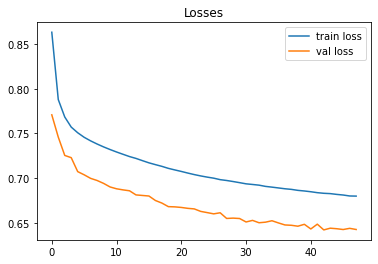

In [17]:
plt.plot(simple_class.history['loss'], label='train loss')
plt.plot(simple_class.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses'); 

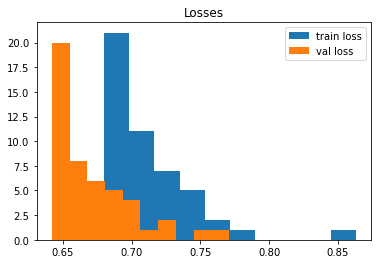

In [18]:
plt.hist(simple_class.history['loss'], label='train loss',bins=10)
plt.hist(simple_class.history['val_loss'], label='val loss',bins=10)
plt.legend()
plt.title('Losses');

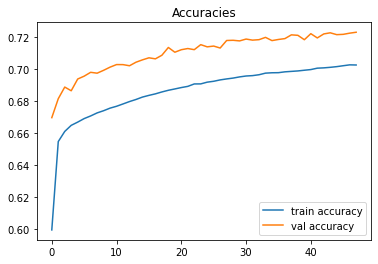

In [19]:
plt.plot(simple_class.history['accuracy'], label='train accuracy')
plt.plot(simple_class.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracies');

In [20]:
pred = deeplob.predict(testX)
predictions=np.round(pred)

972/972 [==============================] - 18s 18ms/step


In [21]:
print('accuracy_score:', accuracy_score(np.argmax(testY, axis=1), np.argmax(predictions, axis=1)))
print(classification_report(np.argmax(testY, axis=1), np.argmax(predictions, axis=1), digits=4))

accuracy_score: 0.7121821046201331
              precision    recall  f1-score   support

           0     0.7151    0.8152    0.7619      8810
           1     0.7037    0.6935    0.6985     10971
           2     0.7184    0.6502    0.6826     11322

    accuracy                         0.7122     31103
   macro avg     0.7124    0.7196    0.7143     31103
weighted avg     0.7122    0.7122    0.7106     31103



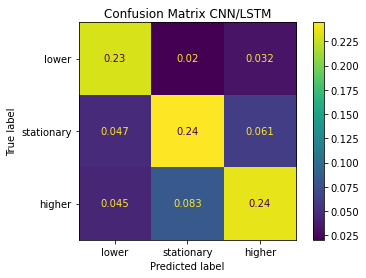

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1),normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['lower','stationary','higher'])
disp.plot()
disp.ax_.set_title("Confusion Matrix CNN/LSTM");

In [23]:
STOP

NameError: name 'STOP' is not defined

LSTM
===

In [ ]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.0001)
loss_function = 'mse'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(horiz, activation='leaky_relu')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function)

lstmMSFT=model.fit(x_vecc_train, r_train, batch_size = batch_size, epochs = num_epochs,validation_data=(x_vecc_val, r_val),callbacks=[callback])

Epoch 1/50
36/36 [==============================] - 18s 426ms/step - loss: 7.8491e-05 - val_loss: 2.2011e-05
Epoch 2/50
36/36 [==============================] - 18s 489ms/step - loss: 2.1164e-05 - val_loss: 1.4983e-05
Epoch 3/50
36/36 [==============================] - 18s 490ms/step - loss: 1.6387e-05 - val_loss: 1.2784e-05
Epoch 4/50
36/36 [==============================] - 18s 488ms/step - loss: 1.4273e-05 - val_loss: 1.0684e-05
Epoch 5/50
36/36 [==============================] - 18s 493ms/step - loss: 1.2437e-05 - val_loss: 1.0096e-05
Epoch 6/50
36/36 [==============================] - 18s 494ms/step - loss: 1.1690e-05 - val_loss: 1.0571e-05
Epoch 7/50
36/36 [==============================] - 18s 491ms/step - loss: 1.0791e-05 - val_loss: 8.6366e-06
Epoch 8/50
36/36 [==============================] - 18s 493ms/step - loss: 9.3221e-06 - val_loss: 7.0731e-06
Epoch 9/50
36/36 [==============================] - 18s 497ms/step - loss: 8.5391e-06 - val_loss: 6.8713e-06
Epoch 10/50
36/36 [

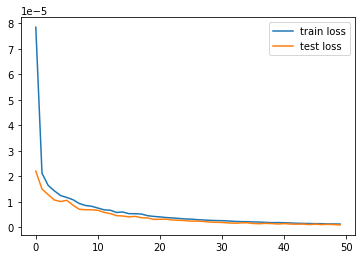

In [ ]:
plt.plot(lstmMSFT.history['loss'], label='train loss')
plt.plot(lstmMSFT.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [ ]:
PtestLSTM = model.predict(x_vecc_test)

1/1 [==============================] - 1s 673ms/step


In [ ]:
trueLSTM=r_test
fcstLSTM=PtestLSTM
u=np.array([np.mean(r[-22:])]).flatten()
num=(true-fcstLSTM)**2
den=(true-np.mean(med[-1:]))**2#trueLSTM-umed[0]erre[0][-22:].flatten()
r2OutSLSTM=((den-num)/den)
r2OutSLSTM

array([[0.74508996]])

ARX-REGRESSION
===

In [ ]:
y=                                                  offlo['r'][:-22].to_numpy()
x=    offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:-22].to_numpy()
xFcst=offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][-22:].to_numpy()
yFcst=                                              offlo['r'][-23:].to_numpy()

mdl = NARX(LinearRegression(), auto_order=1, exog_order=[100,100,100,100,100,100])
mdl.fit(x,y)

y_forecast = mdl.forecast(x, y, step=23, X_future=xFcst)
y_forecast,yFcst

In [ ]:
fore22=y_forecast[0]-y_forecast[-1]
vero22=yFcst[0]-yFcst[-1]
veroBar=np.mean(yFcst)
num=(vero22-fore22)**2
den=(vero22-veroBar)**2
r2OutSARX=((den-num)/den)
r2OutSARX

0.9996518254692212

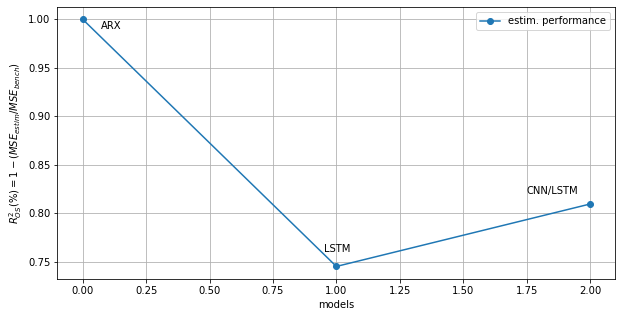

In [ ]:
dict={'ARX':0.9996518254692212,'LSTM':0.74508996,'CNN/LSTM':0.80939784}
topl=pd.DataFrame([dict])
dd=np.zeros(3)
toplot=[r2OutSARX,
r2OutSLSTM,
r2OutS_modello]
for i in range(1,3):
    dd[i]=1/(toplot[i-1]-toplot[i])
plt.figure(figsize=(10,5))
plt.plot(toplot,'o-',label='estim. performance')
plt.annotate('ARX'     , (0.07,0.99))
plt.annotate('LSTM'    ,(.95,0.76))
plt.annotate('CNN/LSTM',(1.75,0.82))
plt.ylabel('$R^2_{OS}(\%)=1- (MSE_{estim} / MSE_{bench})$')
plt.xlabel('models')
plt.grid(True)
plt.legend()
plt.savefig("MSFT_res.pdf")
plt.show()